# Task 3 overview: Dialy sentiment and daily stocks:
Steps:
Aggregate Daily Sentiment:

First, we need to aggregate the daily sentiment scores from the news_df (the news data) based on the date column. This could be done by computing an average sentiment score for each day if there are multiple headlines on the same day.
Match Dates and Add Sentiment:

Once we have the daily sentiment scores, we can iterate over the stock_df and for each row, match the date in stock_df with the date in the aggregated daily_sentiment DataFrame, then append the sentiment score to the stock_df.

In [24]:
import pandas as pd
from textblob import TextBlob
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

In [6]:
# Define the path to the data folder and CSV files
data_folder = '../data'
stock_csv_files = ['AAPL_historical_data.csv', 'AMZN_historical_data.csv', 'GOOG_historical_data.csv', 
                   'META_historical_data.csv', 'MSFT_historical_data.csv', 'NVDA_historical_data.csv', 
                   'TSLA_historical_data.csv']
news_csv = '../data/raw_analyst_ratings.csv'

# Load the news data
news_data = pd.read_csv(f'{data_folder}/{news_csv}')

In [16]:
news_data.head(2)

,Unnamed: 0,headline,url,publisher,date,stock
0,0,Stocks That Hit 52-Week Highs On Friday,https://www.benzinga.com/news/20/06/16190091/s...,Benzinga Insights,2020-06-05 10:30:54-04:00,A
1,1,Stocks That Hit 52-Week Highs On Wednesday,https://www.benzinga.com/news/20/06/16170189/s...,Benzinga Insights,2020-06-03 10:45:20-04:00,A


In [12]:
# Ensure the 'date' column is in the correct format
# Handle mixed formats
news_data['date'] = pd.to_datetime(news_data['date'], errors='coerce')


# daily sentiments

In [17]:
# Function to get sentiment polarity (-1 to 1 scale)
def get_sentiment(text):
    return TextBlob(text).sentiment.polarity

# Apply sentiment analysis to news headlines
news_data['sentiment'] = news_data['headline'].apply(get_sentiment)

# Aggregate average sentiment score for each day
daily_sentiment = news_data.groupby(['date', 'stock'])['sentiment'].mean().reset_index()


In [30]:
daily_sentiment.head(3)

,date,stock,sentiment
0,2011-04-27,DGP,0.000000
1,2011-04-28,ESR,0.136364
2,2011-04-28,DEJ,0.000000


**key steps:**
- Daily Performance Metric: We'll compute a relevant stock performance metric based on available columns like Open, High, Low, Close, Adj Close, Volume, Dividends, and Stock Splits.
Daily Percentage Change in Adjusted Close (Adj Close) could be a strong indicator of daily stock performance.
- Sentiment Aggregation: We'll aggregate the daily sentiment scores and compute the correlation between stock performance (percentage change) and sentiment scores.
- Visualization: We'll plot the stock performance metric and daily sentiment scores with dates on the x-axis.

In [26]:
def calculate_daily_performance(stock_df):
    # Calculate daily percentage change in 'Adj Close'
    stock_df['daily_performance'] = stock_df['Adj Close'].pct_change() * 100
    return stock_df


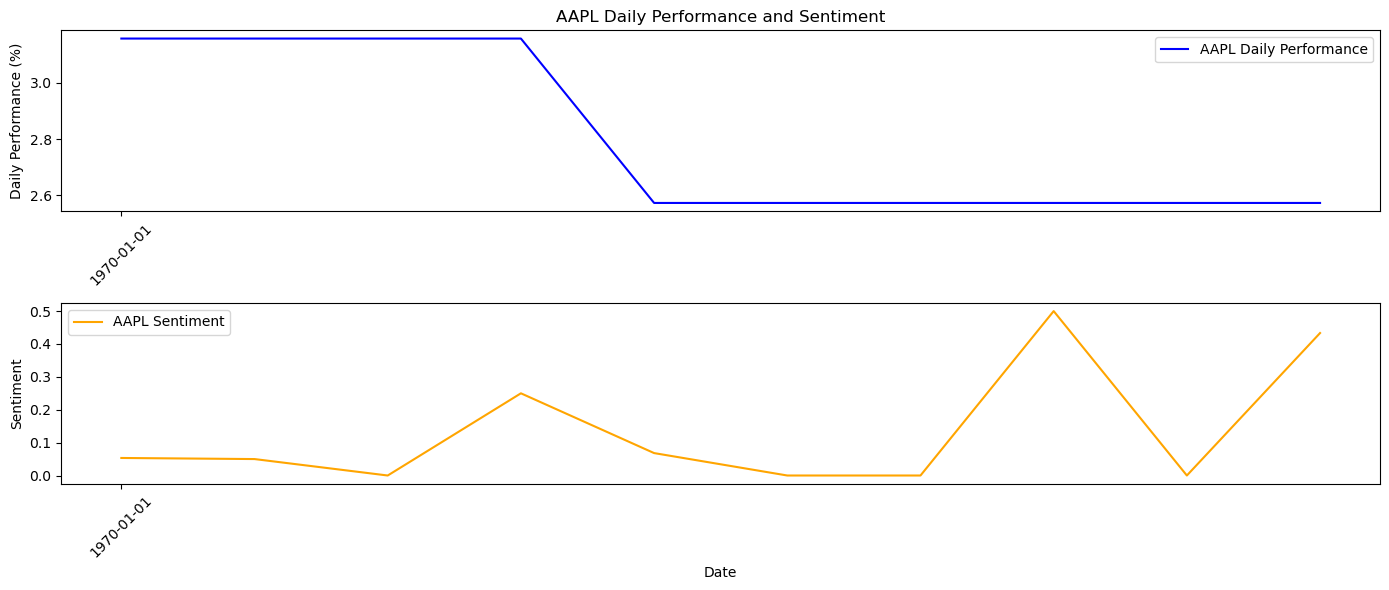

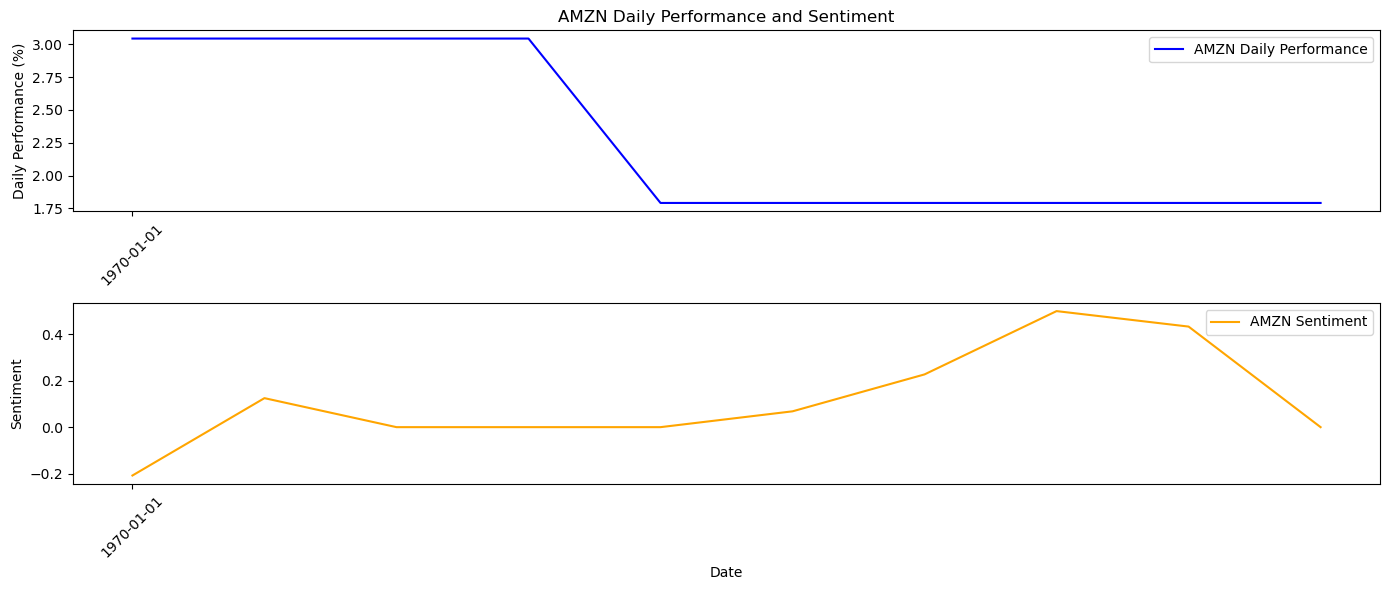

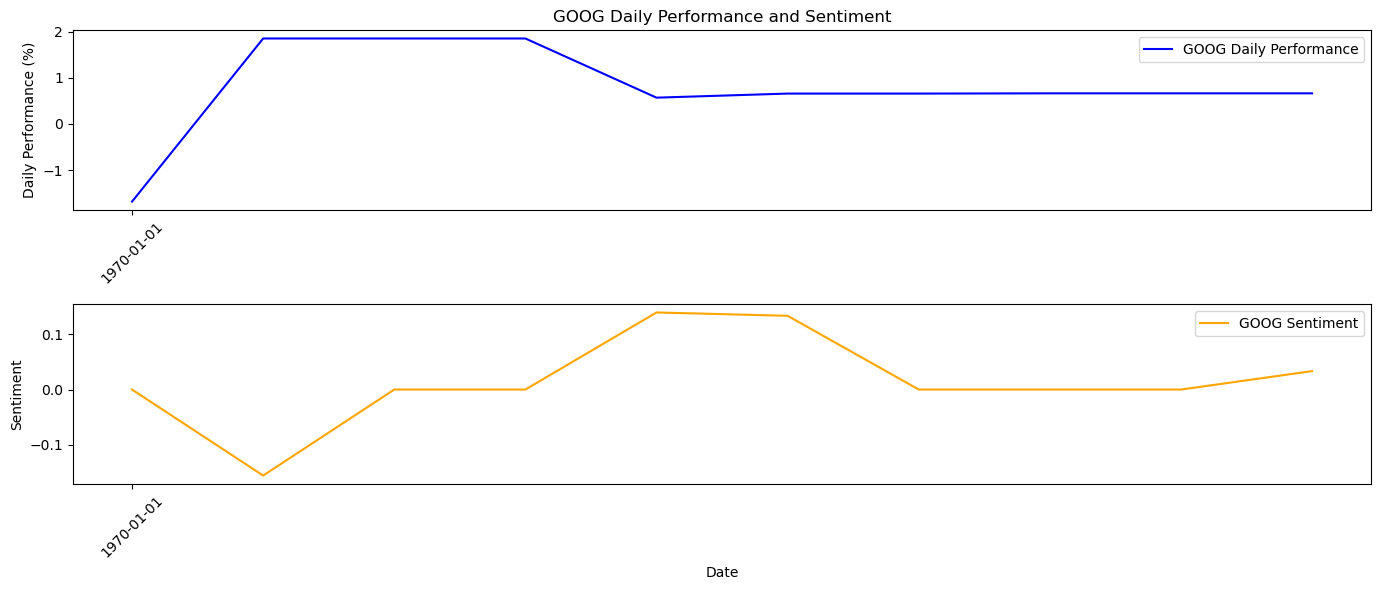

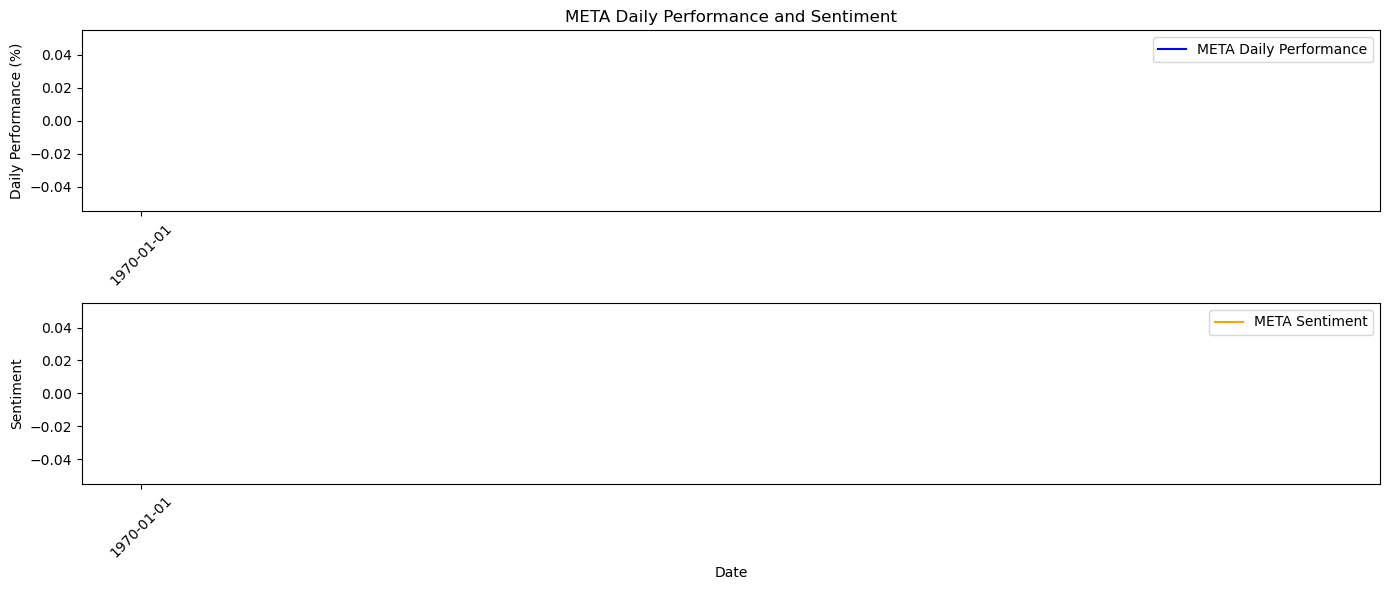

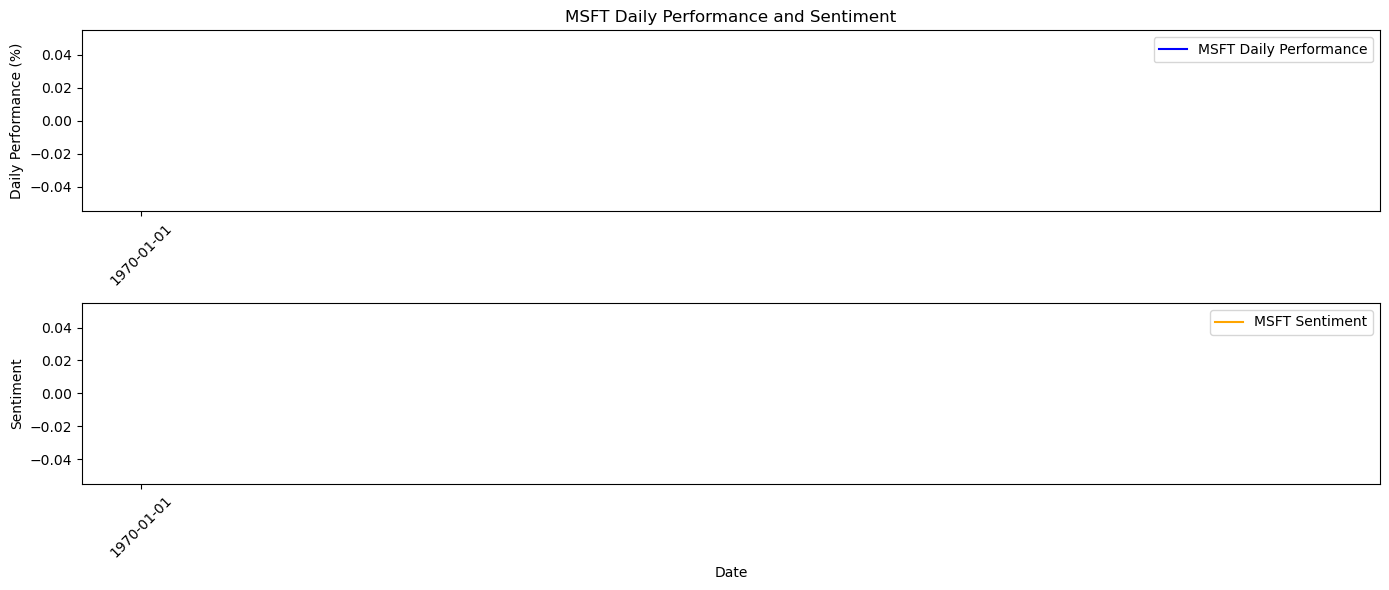

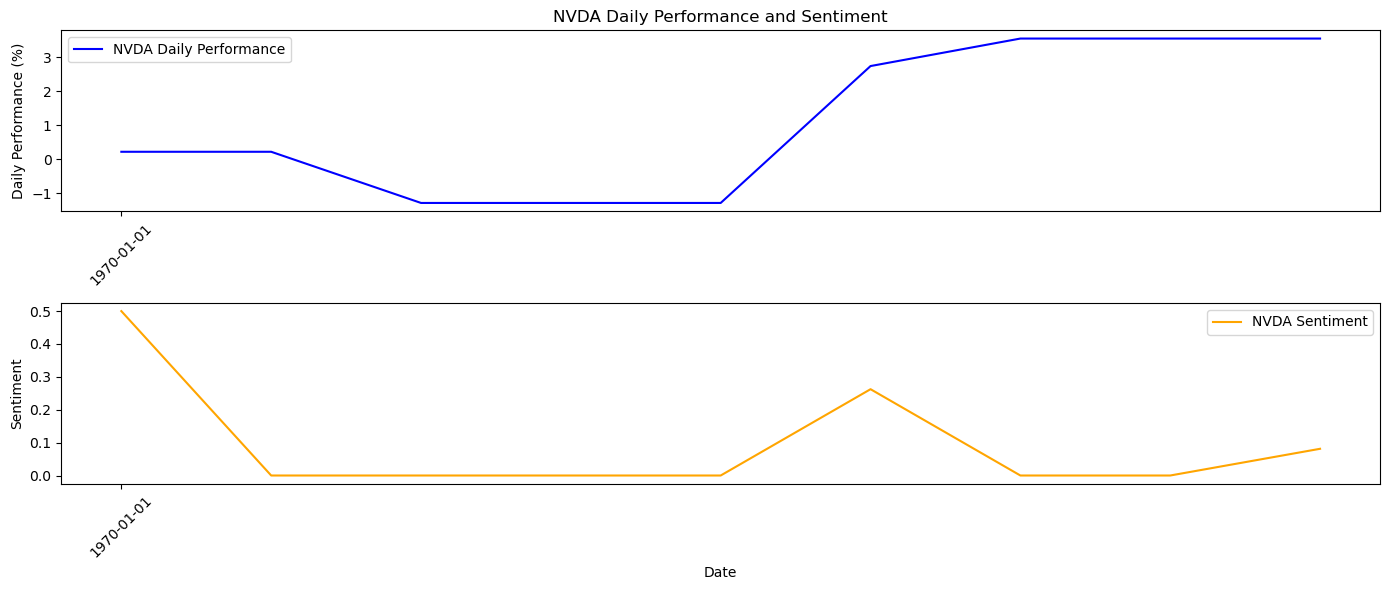

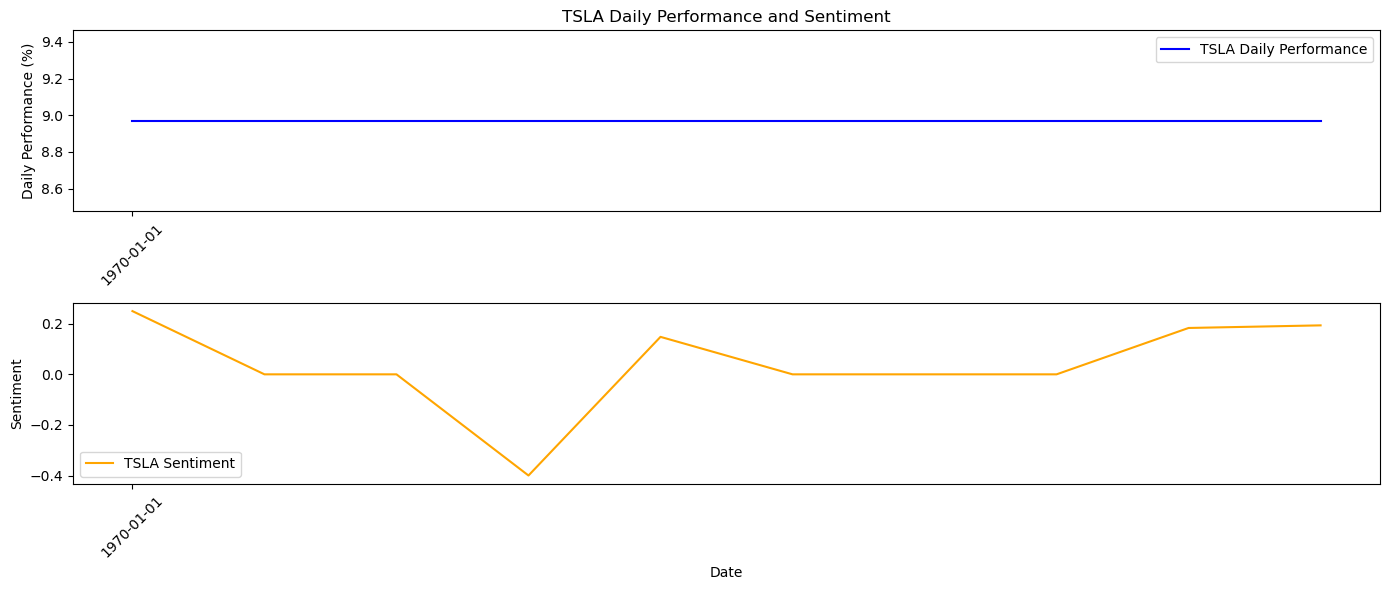

C:\Users\Dave\Anaconda3\lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


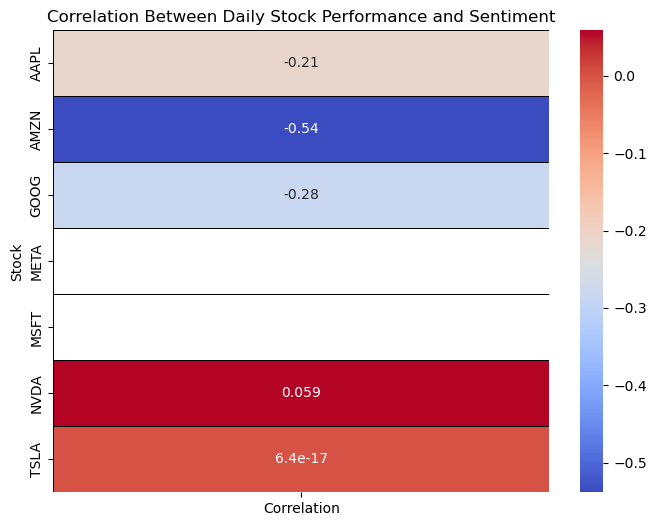

In [27]:
# Initialize list to store correlation results
correlation_results = []

# Loop through each stock CSV file
for stock_file in stock_csv_files:
    # Load the stock data
    stock_df = pd.read_csv(f'{data_folder}/{stock_file}')
    
    # Convert 'Date' column to datetime and set as index
    stock_df['date'] = pd.to_datetime(stock_df['Date']).dt.date
    stock_df.set_index('date', inplace=True)
    
    # Calculate daily performance (percentage change)
    stock_df = calculate_daily_performance(stock_df)
    
    # Extract stock name from the filename
    stock_name = stock_file.split('_')[0]
    
    # Merge stock data with daily sentiment based on 'date' and 'stock'
    merged_df = pd.merge(stock_df, daily_sentiment[daily_sentiment['stock'] == stock_name], on='date', how='inner')
    
    # Calculate Pearson correlation between daily performance and sentiment scores
    correlation = merged_df['daily_performance'].corr(merged_df['sentiment'])
    correlation_results.append((stock_name, correlation))
    
    # Plotting the data for each stock
    plt.figure(figsize=(14, 6))
    
    # Plot daily performance
    plt.subplot(2, 1, 1)
    plt.plot(merged_df.index, merged_df['daily_performance'], label=f'{stock_name} Daily Performance', color='blue')
    plt.title(f'{stock_name} Daily Performance and Sentiment')
    plt.ylabel('Daily Performance (%)')
    plt.legend()

    # Format x-axis for dates
    plt.gca().xaxis.set_major_locator(mdates.YearLocator())  # Major ticks at each year
    plt.gca().xaxis.set_minor_locator(mdates.MonthLocator())  # Minor ticks at each month
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # Format the date labels
    plt.xticks(rotation=45)  # Rotate the date labels for better readability

    # Plot sentiment scores
    plt.subplot(2, 1, 2)
    plt.plot(merged_df.index, merged_df['sentiment'], label=f'{stock_name} Sentiment', color='orange')
    plt.ylabel('Sentiment')
    plt.xlabel('Date')
    plt.legend()

    # Format x-axis for dates
    plt.gca().xaxis.set_major_locator(mdates.YearLocator())
    plt.gca().xaxis.set_minor_locator(mdates.MonthLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

# Creating the correlation DataFrame
correlation_df = pd.DataFrame(correlation_results, columns=['Stock', 'Correlation'])
correlation_df.set_index('Stock', inplace=True)

# Plot Correlation Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_df, annot=True, cmap='coolwarm', linewidths=0.5, linecolor='black')
plt.title('Correlation Between Daily Stock Performance and Sentiment')
plt.show()


# Key Findings

## Daily Performance Metric

The daily performance metric is calculated as the percentage change in the adjusted close price of each stock, providing insight into daily fluctuations in stock value.

## Observations

- **AAPL**: Correlation coefficient of -0.21, indicating a slight negative relationship between daily sentiment and performance.
- **AMZN**: Strong negative correlation at -0.54, suggesting that lower sentiment is associated with poorer stock performance.
- **GOOG**: Negative correlation of -0.28, reflecting a similar trend to AAPL and AMZN.
- **NVDA**: Very weak positive correlation of 0.059, implying little to no relationship between sentiment and performance.
- **TSLA**: Correlation is nearly zero, indicating no significant relationship between sentiment and daily performance.
- **META** and **MSFT**: Insufficient data to compute correlation values.

## Correlation Heatmap

The heatmap confirms the varied correlations between daily performance and sentiment across different stocks, emphasizing the complexities involved in interpreting these relationships.

## Graphical Visualizations

- The line plots effectively illustrate the trends in daily performance and sentiment scores for each company over time, highlighting fluctuations and potential anomalies in the data.
  
## Conclusion

The analysis reveals that while some stocks exhibit a clear negative correlation between daily sentiment and stock performance, others show minimal or no correlation. This underscores the complexity of market dynamics, indicating that sentiment does not always predict stock performance reliably.